# Numerical Recipes Workshop 6

Week 1Nov - 6 Nov 2021

**Please submit your notebook via Noteable by the Friday 6pm. 
 
**IMPORTANT!** Before submitting your notebook, clear the output by clicking *Restart & Clear Output* from the *Kernel* menu. If you do not do this, the file size of your notebook will be very large.

### Learning Objectives

* Curve fitting 
* Least square fitting
* Linear regression 
* Maximum likelihood modeling

Please complete the workshop notebook before beginning on the checkpoint. **The workshop notebooks demonstrate everything you need to complete the checkpoints.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scopt
import scipy.linalg
import scipy.stats
%matplotlib inline

# Curve fitting 

The curve fitting is usually done by optimizing the chi-square statistic which is is the sum
 of squares of residuals between the data and the model normalized by the errors
    
In python the simplest way to do that is with  `scipy.optimize.curve_fit`

Here we are going to fit the data with the model 
$$y = p_0 + p_1  x + exp(p_2  x) + p_3  arctan(p_4*x)$$
Lets first generate the data

<ErrorbarContainer object of 3 artists>

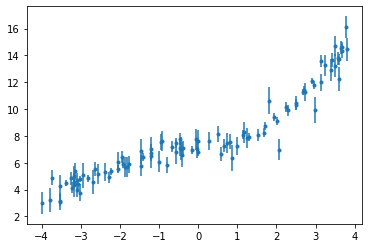

In [2]:
# true value of our parameters 
ptrue = [6, 1, .5, 3, 4]

rng = np.random.default_rng(323)
def gendata(N):
    xs = rng.uniform(-4, 4, N)
    errs = rng.uniform(.2,1,N)
    ytrue = ptrue[0] + ptrue[1] * xs + np.exp(ptrue[2] * xs) - np.arctan(ptrue[3]*xs) 
    ys = ytrue + np.random.normal(size=N)*errs
    return xs, ys, errs

X, Y, E = gendata(100)
plt.errorbar(X, Y, E, fmt='.')


# Challenge

Fit the data using curve_fit(). Make sure to provide the uncertainties on Y as well 
as the starting point of the fit. 

Check that you extract parameter values that are close to ptrue.

Verify the impact of specifying different starting points p0. For example try to start from point [10,10,10,10] and see 
the impact of that.

The curve_fit also returns the covariance matrix on the measured parameters which is the measure of uncertainties and correlations between measured parameters. Use the `np.sqrt(np.diag(cov))` to extra the standard deviation (uncertainties) vector for the parameters.

In [24]:
def modelfunc(xdata, p0, p1, p2, p3,):
    return p0 + p1 * xdata + np.exp(p2*xdata) - np.arctan(p3*xdata) 
# YOUR CODE HERE
curvefit = scipy.optimize.curve_fit(modelfunc, X, Y, sigma=E,p0=[1,1,1,1])
curvefit[0]
np.abs(curvefit[0]-ptrue[:-1])

array([0.05481487, 0.00833475, 0.00341513, 0.74547341])

In [15]:
curvefit = scipy.optimize.curve_fit(modelfunc, X, Y, sigma=E,p0=[10,10,10,10])
curvefit[0]

array([5.91696446e+00, 1.04283769e+00, 5.10442067e-01, 8.31737012e+14])

# Least-squares fit

While the curve_fit is a convenient method of fitting 1D curves 

a more generic fitting routine is `scipy.optimize.least_squares` that optimizes the sum of squares of values returned by your function. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

The `scipy.optimize.least_squares` expects a function that takes parameters as a vector and then returns the vector of deviations between data and model 

```
def func(p, ... ):
    return (data-model)/err
```

The `least_squares` then minimizes the sum of squares of all the values returned by this function.

### Challenge

Fit the same parametric model to the data we obtained before by using least_squares() routine.

In [52]:
def modelfunc2(p, x, y, err):
    model = p[0] + p[1] * x + np.exp(p[2] * x) - np.arctan(p[3] * x)
    resid = (y-model)/err
    return resid
f = modelfunc2(ptrue,X,Y,E)
# YOUR CODE HERE
least_squares = scipy.optimize.least_squares(modelfunc2,[1,1,1,1],args=(X,Y,E))
least_squares.x

array([ 1.67991169e-01,  1.71590738e+00, -9.12876581e-05,  9.71765599e+00])

# Linear regression 


A large range of models are linear in their parameteters, for example the models fitting the data by polynomials

$$ y = p_0 + p_1  x + p_2  x^2 + p_3 x ^3$$

It is important that although the model itself is not linear, it is linear with respect to the parameters $p_i$. 
That allows us to more efficiently fit it using for example `scipy.linalg.lstsq` https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html which is the procedure that does *NOT* requires iteratively minimizing a function. 

## Challenge

To fit using the lstsq we need to construct the design matrix A and the data vector D. 

Remember that the design matrix is such a matrix that the model vector $M$ could be written as
$$ M = A p $$

where p is the vector of parameters. 

With the design matrix and data vector the `lstsq` routine will find the parameter vector minimizing $||D-Ap||^2$ where ||.|| is the norm (or Euclidean length) operator.

First lets generate the data using 3rd order polynomial

<ErrorbarContainer object of 3 artists>

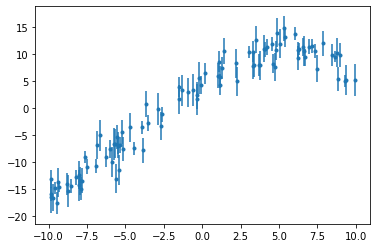

In [111]:
ptrue = [5, 2, -.1, -.01]
rst = np.random.default_rng(434)
def gendata(N):
    xs = rst.uniform(-10, 10, N)
    ys = ptrue[0] + ptrue[1] * xs + ptrue[2]*xs**2 + ptrue[3]*xs**3
    errs = rst.uniform(1,3,N)
    ys = ys + rst.normal(size=N) * errs
    return xs, ys, errs

X, Y, E = gendata(100)
plt.errorbar(X, Y, E, fmt='.')

Now you need to write the function that does the linear regression fitting below. 


You need to construct the design matrix A which should be the matrix with the size (N,4) where N is the number of 
datapoints. First we'll construct it ignoring the uncertainties. 

Your function should return the best fit parameter vector and the sum of squares of deviations. 
(notice that `lstsq` returns the array of deviations for the best fit)

In [114]:
def fit_linmodel(X, Y):
    N = len(X)
    M = np.zeros((N, 4)) # design matrix
    # YOUR CODE HERE
    for i in range(4):
        M[:,i] = X**i 
    val = scipy.linalg.lstsq(M, Y)
    p = val[0]
    res = val[1]
    
    return p, res
print (fit_linmodel(X,Y))

# check that we got reasonably close to the true params
assert(np.all(np.abs(fit_linmodel(X, Y) [0]-ptrue) < 10**(-0.5*np.arange(4))))

(array([ 4.72254255,  1.94792993, -0.09925599, -0.00879029]), 377.1154229136162)


In [122]:
x = np.linspace(-10,10,100)
def poly(x,p0,p1,p2,p3):
    return p0 + p1*x + p2*x**2 + p3*x**3
    

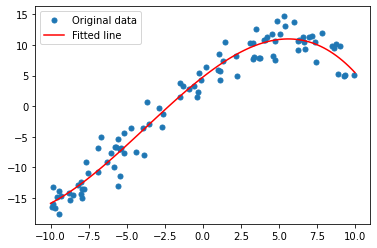

In [128]:
p = fit_linmodel(X, Y)[0]
_ = plt.plot(X, Y, '.', label='Original data', markersize=10)
_ = plt.plot(x, poly(x, p[0], p[1], p[2], p[3],), 'r', label='Fitted line')
_ = plt.legend()
plt.show()

# Regression with uncertainties

Now lets take into account the uncertainties in the fit. To do that we we'll need to divide the
data vector by errors and the design matrix by the errors. Then we'll run the lstsq as before. 

Update the fit_linmodel code below. Fit the data and overplot the bestfit model on top of the data

In [70]:
np.shape(E)

(100,)

In [129]:
def fit_linmodel_with_errors(X, Y, E):
    # YOUR CODE HERE
    N = len(X)
    M = np.zeros((N, 4)) # design matrix
    # YOUR CODE HERE
    for i in range(4):
        M[:,i] = X**i/E
    Y_tilda = Y/E
    return scipy.linalg.lstsq(M, Y_tilda)
fit_linmodel_with_errors(X, Y, E)
assert(np.all(np.abs(fit_linmodel_with_errors(X, Y,E) [0]-ptrue) < 10**(-0.5*np.arange(4))))

In [130]:
p = fit_linmodel_with_errors(X, Y, E)[0]
p

array([ 4.88848503,  2.00904226, -0.10037387, -0.0098182 ])

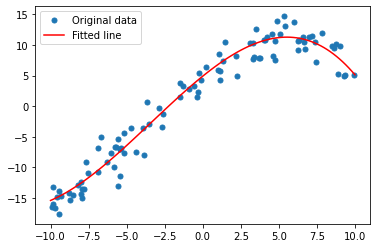

In [131]:
p = fit_linmodel_with_errors(X, Y, E)[0]
_ = plt.plot(X, Y, '.', label='Original data', markersize=10)
_ = plt.plot(x, poly(x, p[0], p[1], p[2], p[3],), 'r', label='Fitted line')
_ = plt.legend()
plt.show()

# Model comparison 

How can we use the results to decide which model fits better ? 
For example if we are fitting polynomial models but we don't know what is the order of the polynomial. 

Use the code developed above to plot the best chi-square of the fit vs degree of the polinomial 
for 1st, 2nd and 3rd degree. 

You should see that the chi-square of the 3rd degree fit is much better, indicating that this our preferred model for the data. 

If you continue to increase the degree you will notice that the chi-squares will continue decreasing but much more slowly. In fact when the number of parameters is drastically different between different models, we often use chi-square + 2 * the number of parameters as our metric https://en.wikipedia.org/wiki/Akaike_information_criterion . This penalizes the models that have too many parameters but provide only marginal improvement in chi-square.

In [132]:
def fit_linmodel_ndeg(X, Y, E, ndeg):
    """ Fit the data Y with uncertainties E 
    by a polynomial model with ndeg degrees
    """
    N = len(X)
    M = np.zeros((N, ndeg)) # design matrix
    # YOUR CODE HERE
    for i in range(ndeg):
        M[:,i] = X**i/E
    Y_tilda = Y/E
    val = scipy.linalg.lstsq(M, Y_tilda)
    p = val[0]
    res = val[1]
    return p, res

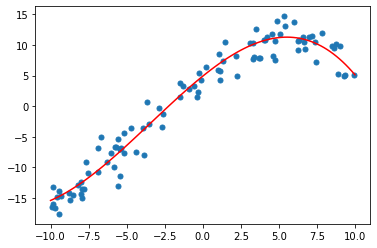

In [140]:
p = fit_linmodel_ndeg(X, Y, E, 4)[0]
_ = plt.plot(X, Y, '.', label='Original data', markersize=10)
_ = plt.plot(x, poly(x, p[0], p[1], p[2], p[3]), 'r', label='Fitted line')

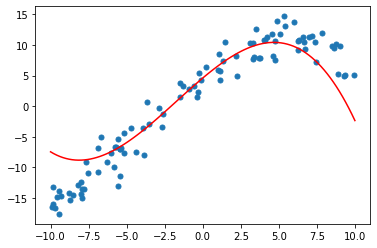

In [142]:
p = fit_linmodel_ndeg(X, Y, E, 8)[0]
_ = plt.plot(X, Y, '.', label='Original data', markersize=10)
_ = plt.plot(x, poly(x, p[0], p[1], p[2], p[3]), 'r', label='Fitted line')

# Maximum likelihood fit

Here we will look at a couple of problems and will code the maximum likelihood (ML) solution. 

The key point for any ML fit is to write the likelihood function correctly. 

Usually the likelihood function will look like this 


```
def like(p, dataa, datab, ..):
    
    return -loglike
    
```

It will take the vector of parameters p, various data and will return the minus log-likelihood

This log-likelihood can then be optimized by `scipy.optimize.minimize`

# Fitting an exponential distribution of arrival times 

First let's code the problem from the lecture where our data is the set of arrival times (from some beta-decay experiment for example). 

And we are trying to model those arrival times by the exponential distribution.

$$P(t|\tau) = \frac{1}{\tau} \exp(-\frac{t}{\tau})$$

The log-likelihood function will be the sum of  $\log(P(t_i|\tau)$ over all the data-points

here are the optimization results
      fun: 335.903138892476
 hess_inv: array([[1.11937883]])
      jac: array([-3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 14
     njev: 15
   status: 0
  success: True
        x: array([10.58069868])
our best fit tau is [10.58069868] the true one is  10


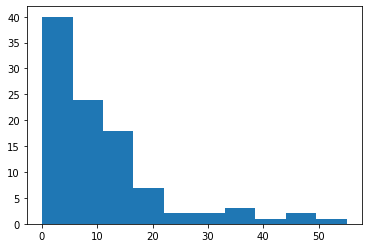

In [144]:
tau_true = 10

def gendata(N):
    """ Return the times from the exponential distribution """
    return scipy.stats.expon(scale=tau_true).rvs(N)

TOBS = gendata(100)

plt.hist(TOBS)

def like(p, TOBS):
    """
    return the -loglikelihood summed over all the data
    """
    
    tau = p[0]
    
    # This is the probability density of each data point under the exponential model
    log_pdf = np.log(1 / tau * np.exp(-TOBS / tau))
    
    loglike =  log_pdf.sum()
       
    return -loglike

print ('here are the optimization results')
res = scipy.optimize.minimize(like,[1],args=(TOBS))
print (res)

print ('our best fit tau is' ,res.x, 'the true one is ', tau_true)


### Challenge
Now use the maximum-likelihood approach and plot how the recovered parameter depends on 
the number of datapoints in the data (from 3 to 10000).
Doe the measurement of tau converge to the true value as we get more data ? 

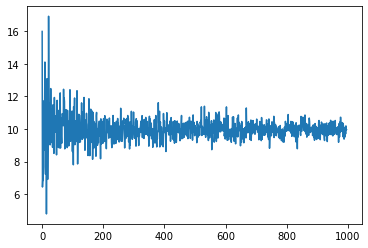

In [150]:
# YOUR CODE HERE
x = []
for N in range(3,1000):
    TOBS = gendata(N)
    res = scipy.optimize.minimize(like,[1],args=(TOBS))
    x.append(res.x)
plt.plot(x)    

# Modeling a 2D distribution of points 

Now lets fit a 2d problem from the lecture. 

Here we are modeling the distribution of particles on the detector by a Normal distribution 

$$P(x,y | c_x, c_y ,s_x,s_y) = \frac{1}{2\pi s_x s_y} \exp\left(-\frac{1}{2}\frac{(x-c_x)^2}{s_x^2}-\frac{1}{2}\frac{(y-c_y)^2}{s_y^2}\right)$$

(-3.0, 15.0)

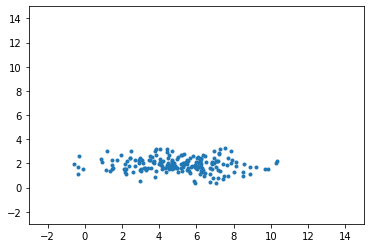

In [156]:
c_xtrue=5,
c_ytrue=2,
s_xtrue=2,
s_ytrue=.6,

def gendata(N):
    xs = np.random.normal(c_xtrue,s_xtrue,N)
    ys = np.random.normal(c_ytrue,s_ytrue,N)
    return xs,ys

X,Y= gendata(200)
plt.plot(X, Y, '.')
plt.xlim(-3, 15)
plt.ylim(-3, 15)


# Challenge 

Write the likelihood function for this data 
and fit the best values of c_x, c_y, s_x, s_y using the maximum likelihood approach. 

Remember the log-likelihood function should be the sume of log-probabilities for each data-point in your data.

Hint: Instead of writing log(exp(-SOMETHING)), it is better to just write -SOMETHING 

When you run the fit you may notice that you get a NaN results. 
This is caused by the fact that if you evaluate your model for negative s_x that will lead to log(negative numbers). 
To prevent this you may want to put in your function the code like: 
```
if not np.isfinite(loglike):
    return 1e10
```
which will basically return a very large value if the loglikelihod function is not finite.

Alternatively you can also use the Nelder-mead optimization instead of BFGS


In [226]:
def like(p, x, y):
    """ Our likelihood function takes as input a parameter vector 
    and the data (x,y)
    """
    c_x, c_y, s_x, s_y=p
    log_pdf = np.log(1 / 2*np.pi*s_x*s_y) + (-0.5*(x-c_x)**2/s_x**2) + (-0.5*(y-c_y)**2/s_y**2)
    loglike =  log_pdf.sum()
    if not np.isfinite(loglike):
        return 1e10
    return -loglike

In [227]:
res = scipy.optimize.minimize(like,x0=(1,1,1,1),args=(X,Y))
res.x

array([  -429099.44258636, -36490134.32017791,   5859070.82833156,
        38884303.76219723])

# Uncertainties from the maximum likelihood fit

To determine the uncertainties on the model parameters we need to determine the 
matrix of second derivatives (or Hessian) of the log-likelihood function

To do that there is a nice package numdifftools https://numdifftools.readthedocs.io/en/latest/tutorials/getting_started.html

In [221]:
# We can install additional packages using a pip command
!pip install numdifftools

In [184]:
import numdifftools

Here I demonstrate how we can determine the Hessian matrix (i.e. matrix of second derivatives) of the function
$$f(x) = x_0^2+ 3 x_1^2 + 4 x_2^4$$
at the location X=[0,0,0]
It should be equal to 
$$\begin{pmatrix}
2 & 0 & 0\\
0 & 6 & 0\\
0 & 0 & 0\\
\end{pmatrix}
$$

In [222]:
def testfunc(p):
    return p[0]**2 + 3*p[1]**2 + 4*p[2]**4

HH = numdifftools.Hessian(testfunc)
print (HH([0, 0, 0]))

[[2.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.73106403e-19]]


Now use the `numdifftools` module to determine the Hessian matrix of the likelihood function in the minimum. To get the uncertainties you need to invert the matrix (`scipy.linalg.inv`), extract the diagonal from it and take the square root of that.

In [223]:
inverse = scipy.linalg.inv(HH([0,0,0]))

In [224]:
res = scipy.optimize.minimize(like, [1, 1, 1, 1], args=(X,Y))
# YOUR CODE HERE
print(res.x)

[  -429099.44258636 -36490134.32017791   5859070.82833156
  38884303.76219723]


In [225]:
inverse = scipy.linalg.inv(HH(res.x))

LinAlgError: singular matrix

# Diming light source problem

You are observing a faint distant object that is becoming fainter and fainter in time. 

Your detector recorded the number of photonos coming from the source when observed for 50 seconds

`
NPHOT = [95, 72, 65, 52, 57, 35, 24, 26, 16, 22, 13, 15, 12,  9,  7,  4,  9,
        2,  2,  0,  3,  3,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
`

in time intervals of 1 second.
You believe that the source brightness is decaying with time as $N_0 \exp(-t/\tau)$.

Assuming that the number of photons coming in each interval can be described by Poisson 
distribution with the rate parameter described by $N_0 \exp(-t/\tau)$, write the likelihood and estimate the parameter tau. 

Your log-likelihood function need to sum over all 50 observations. And remember that you can 
use `scipy.stats.poisson` and it's `pmf` method to estimate the likelihood of each observation

Your model will need to have two parameters $N_0$ and $\tau$

In [ ]:
NPHOT = [95, 72, 65, 52, 57, 35, 24, 26, 16, 22, 13, 15, 12,  9,  7,  4,  9,
        2,  2,  0,  3,  3,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
plt.plot(NPHOT,'.')

# Challenge

Write the likelihood and find the best value of $\tau$. Overplot your best model on top of the data. 

In [ ]:
def like(p, nphot):
    n0, tau = p
    # YOUR CODE HERE
    raise NotImplementedError()